In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf

In [2]:
# **Loading Dataset**
data_train = np.load('/content/train_set.npz', allow_pickle=True)
x_train = data_train['arr_0']
y_train = data_train['arr_1']

data_test = np.load('/content/train_set.npz', allow_pickle=True)
x_test = data_test['arr_0']
y_test = data_test['arr_1']

In [3]:
train_data_generator = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,  # Vertical flip might not make sense depending on your dataset

)


x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=60,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
#                                     brightness_range=[0.5, 1.5],
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(5):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

1440
1440
1512
1512
360
360
432
432


In [5]:
# **Data Preprocessing**
x_train = np.array(x_train)
x_test = np.array(x_test)

# Initialize new arrays for resized images
x_train_resized = np.empty((x_train.shape[0], 224, 224, 3), dtype=np.float32)
x_test_resized = np.empty((x_test.shape[0], 224, 224, 3), dtype=np.float32)


for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (224, 224))  # DenseNet201 requires 224x224 input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train_resized[i] = img

for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test_resized[i] = img

# Normalize the images
x_train_resized /= 255.0
x_test_resized /= 255.0

# Use the resized images for training and testing
x_train = x_train_resized
x_test = x_test_resized

# Encoding labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [6]:
# **Model Defining**
def create_densenet201_model(input_shape=(224, 224, 3)):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
model = create_densenet201_model()
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 94080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 94080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,021,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,343,298 (92.86 MB)

 Trainable params: 6,021,314 (22.97 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [8]:
# **Model Training**
hist = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6421 - loss: 0.8303 - val_accuracy: 0.8750 - val_loss: 0.3176
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 141ms/step - accuracy: 0.8597 - loss: 0.3079 - val_accuracy: 0.8750 - val_loss: 0.2866
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9037 - loss: 0.2315 - val_accuracy: 0.9468 - val_loss: 0.1706
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.9209 - loss: 0.1942 - val_accuracy: 0.9606 - val_loss: 0.1416
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.9575 - loss: 0.1218 - val_accuracy: 0.9606 - val_loss: 0.1299
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.9677 - loss: 0.0953 - val_accuracy: 0.9630 - val_loss: 0.1058
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9785 - loss: 0.0767 - val_accuracy: 0.9653 - val_loss: 0.0961
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9828 - loss: 0.0601 - val_accuracy: 0

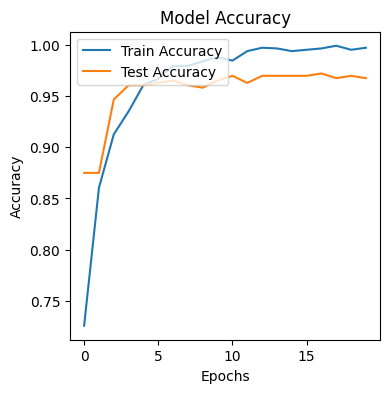

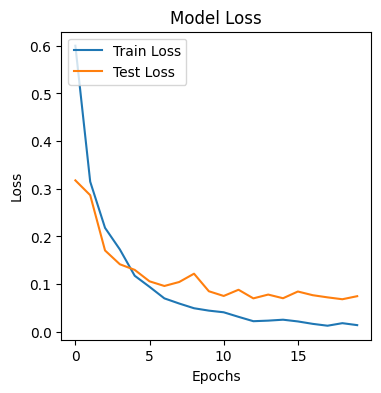

In [10]:
# **Visualization of Training History**
plt.figure(figsize=(4, 4))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()


In [11]:
# **Evaluation**
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       216
           1       0.99      0.94      0.97       216

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



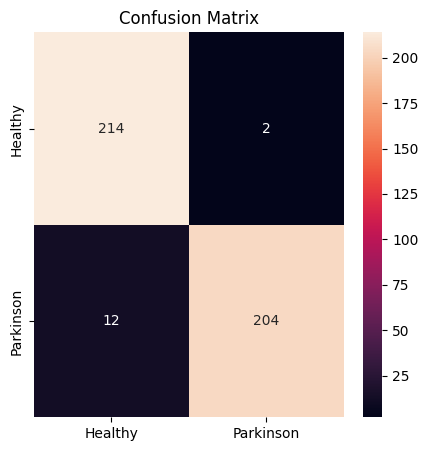

In [12]:
# **Confusion Matrix**
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=['Healthy', 'Parkinson'], columns=['Healthy', 'Parkinson'])
plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# **Testing with Sample Images**
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread('Parkinson_disease_detection/test_image_healthy.png')
image_parkinson = cv2.imread('Parkinson_disease_detection/test_image_parkinson.png')

def prepare_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image


In [ ]:
image_healthy_prepared = prepare_image(image_healthy)
image_parkinson_prepared = prepare_image(image_parkinson)

ypred_healthy = model.predict(image_healthy_prepared)
ypred_parkinson = model.predict(image_parkinson_prepared)


In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(image_healthy_prepared[0])
plt.axis('off')
plt.title(f'Prediction: {labels[np.argmax(ypred_healthy[0])]}')
plt.show()

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(image_parkinson_prepared[0])
plt.axis('off')
plt.title(f'Prediction: {labels[np.argmax(ypred_parkinson[0])]}')
plt.show()

In [ ]:
model.save('parkinson_disease_detection_densenet201.h5')